In [24]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import camera_calibrator
import image_undistorter
import image_binary_thresholder
import perspective_transformer
%matplotlib inline

test_dir = 'test_images/'
cal_dir = 'camera_cal/'
out_dir = 'output_images/'

In [17]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


def get_undistorted_image(fname, mtx, dist, gray_scale=False):
    img_orig = cv2.imread(fname)
    img_undist = undistort(img_orig, mtx, dist)
    color_profile = cv2.COLOR_BGR2GRAY if gray_scale else cv2.COLOR_BGR2RGB
    return cv2.cvtColor(img_undist, color_profile)


def plot_comparison(img1, img2, gray_first=False, gray_second=False):
    plt.subplot(1,2,1)
    plt.imshow(img1,'gray' if gray_first else None)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray' if gray_second else None)
    plt.axis('off')

Starting camera calibration
Camera calibrated using 20 images


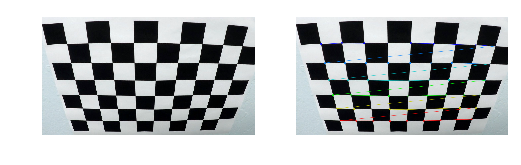

In [18]:
print('Starting camera calibration')
images = []

img, gray, img_corners, img_original = None, None, None, None

objpoints, imgpoints = [], []

image_files = glob.glob('camera_cal/calibration*.jpg')

for fname in image_files:

    nx, ny = 9, 6

    if 'calibration1.jpg' in fname:
        nx, ny = 9, 5
    if 'calibration4.jpg' in fname:
        nx, ny = 6, 5
    if 'calibration5.jpg' in fname:
        nx, ny = 7, 6

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # Save example image and corresponding identified corners
    if 'calibration2.jpg' in fname:
        img_original = img.copy()
        img_corners = img.copy()
        img_corners = cv2.drawChessboardCorners(img_corners, (nx, ny), corners, ret)
        cv2.imwrite('output_images/chessboard_original.jpg', img_original)
        cv2.imwrite('output_images/chessboard_corners.jpg', img_corners)

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        images.append(img)
    else:
        print('Did not find corners', fname, (nx, ny))

plot_comparison(img_original, img_corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print('Camera calibrated using {0} images'.format(np.array(images).shape[0]))

True

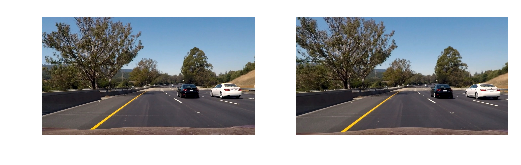

In [19]:
image_files = glob.glob(test_dir + '*.jpg')

for fname in image_files:
    org_img = cv2.imread(fname)
    undist = undistort(org_img, mtx, dist)
    
    fname = fname.replace(test_dir, out_dir + 'undistorted_')
    cv2.imwrite(fname, undist)
    
    org_img = cv2.cvtColor(org_img, cv2.COLOR_RGB2BGR)
    undist = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
    plot_comparison(org_img, undist)
    
cal_img_orig = cv2.imread(cal_dir + 'calibration2.jpg')
cal_img_undist = undistort(cal_img_orig, mtx, dist)
cv2.imwrite(out_dir + 'chessboard_undistort.jpg', cal_img_undist)

True

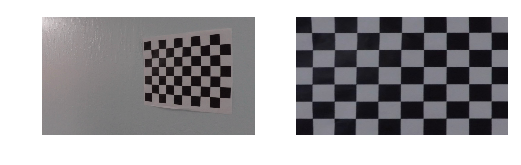

In [23]:
# Camera calibration sample image and corresponding parameters
cal_file = 'calibration12'
nx, ny = 9, 6
offset = 100 

# Read image file, undistort, covert to grayscale and find chessboard corners
fname = cal_dir + cal_file + '.jpg'
cal_img_orig = cv2.imread(fname)
gray_undist = get_undistorted_image(fname, mtx, dist, gray_scale=True)
color_undist = get_undistorted_image(fname, mtx, dist, gray_scale=False)
ret, corners = cv2.findChessboardCorners(gray_undist, (nx, ny), None)
x, y = gray_undist.shape[::-1]

# Identify outer corners. Top-left, top-right, bottom-left, bottom-right.
src = np.float32([corners[0][0], corners[nx-1][0], corners[nx*(ny-1)][0], corners[nx*ny-1][0]])

# Create rectangle with corners positioned with a distance [offset, offset] from image frame corners
dst = np.float32([[offset, offset],[x-offset, offset],[offset, y-offset],[x-offset, y-offset]])

# Get perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Calculate top-down image using perspective transform matrix
warped = cv2.warpPerspective(color_undist, M, (x, y), flags=cv2.INTER_LINEAR)

# Plot comparison
plot_comparison(cal_img_orig, warped)

# Save example images to disk
cv2.imwrite(out_dir + cal_file + '_original.jpg', cal_img_orig)
cv2.imwrite(out_dir + cal_file + '_perspective_transform.jpg', warped)

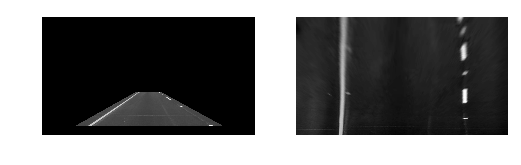

In [48]:
file = 'straight_lines1'
img_file_name = test_dir + file + '.jpg'

# Camera calibration
mtx, dist = camera_calibrator.get_camera_calibration_matrix()

# Get undistorted image
undistorted_gray = image_undistorter.get_undistorted_image(img_file_name, mtx, dist, gray_scale=True)

# Thresholded image
binary_thresholded = image_binary_thresholder.get_binary(undistorted_gray)

image = undistorted_gray
y, x = image.shape # Image size
x_mid = x/2

# Trapezoid shape
x_top = 0.12 * x # Width at top border
x_bottom = 0.68 * x # Width at bottom border
y_top = 0.64 * y # Top border position
y_bottom = 0.92 * y # Bottom border position

top_left = [x_mid - x_top/2, y_top]
top_right = [x_mid + x_top/2, y_top]
bottom_left = [x_mid - x_bottom/2, y_bottom]
bottom_right = [x_mid + x_bottom/2*1.02, y_bottom]

src = np.float32([top_left, top_right, bottom_left, bottom_right])
offset = 0.25 * min(y, x)
dst = np.float32([[offset, offset], [x - offset, offset], [offset, y], [x - offset, y]])

mask = cv2.fillPoly(np.copy(image), [np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)], 0)
masked = image - mask

# Get perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Calculate top-down image using perspective transform matrix
warped = cv2.warpPerspective(image, M, (x, y), flags=cv2.INTER_LINEAR)

cv2.imwrite(out_dir + file + '_masked.jpg', masked)
cv2.imwrite(out_dir + file + '_masked_transformed.jpg', warped)
plot_comparison(image, masked, gray_first=True, gray_second=True)
plot_comparison(masked, warped, gray_first=True, gray_second=True)

True

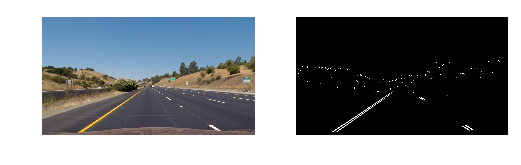

In [21]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel = sobely if orient is 'y' else sobelx
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary =  np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    
    return dir_binary


# Sample image
file = 'straight_lines1'
fname = test_dir + file + '.jpg'

# Undistortet image in color, gray
gray = get_undistorted_image(fname, mtx, dist, gray_scale=True)
color = get_undistorted_image(fname, mtx, dist, gray_scale=False)

# Choose a Sobel kernel size
ksize = 25 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(65, 250))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(65, 250))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(100, 250))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(np.pi/4*0.6, np.pi/4*1.5))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plot_comparison(color, combined, gray_second=True)

cv2.imwrite(out_dir + 'undistorted_' + file + '_binary_thresholded.jpg', combined*255)